In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import re
from urllib.parse import urlparse

In [2]:


phishing_data = pd.read_csv('phishing.csv')
print(len(phishing_data))

umbrella_data = pd.read_csv('umbrella_top_1m.csv', names=['rank', 'domain'])

55405


In [3]:


def extract_domain(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return domain

phishing_data['domain'] = phishing_data['url'].apply(extract_domain)


In [4]:
phishing_data['label'] = 1
umbrella_data['label'] = 0

In [5]:


phishing_samples = phishing_data.sample(n=3000, random_state=42)

umbrella_samples = umbrella_data.iloc[:3000]

balanced_data = pd.concat([phishing_samples[['domain', 'label']], umbrella_samples[['domain', 'label']]], ignore_index=True)

balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(len(balanced_data))

6000


In [6]:
missing_data = balanced_data.isnull().sum()
print("Eksik Veri Analizi:")
print(missing_data)

Eksik Veri Analizi:
domain    0
label     0
dtype: int64


In [7]:
print(balanced_data[:5])

                      domain  label
0         fi4tfn.webwave.dev      1
1  suggestqueries.google.com      0
2                    ipfs.io      1
3    ipfs.eth.aragon.network      1
4   3-courier.push.apple.com      0


In [8]:
balanced_data.to_csv('balanced_data.csv', index=False)

print("balanced_data.csv kaydedildi.")

balanced_data.csv dosyası başarıyla kaydedildi.


In [9]:



vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
X = vectorizer.fit_transform(balanced_data['domain'])
y = balanced_data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  
    tnr = tn / (tn + fp)  

 
    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        else:
            y_prob = model_obj.decision_function(X_test)

        fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }

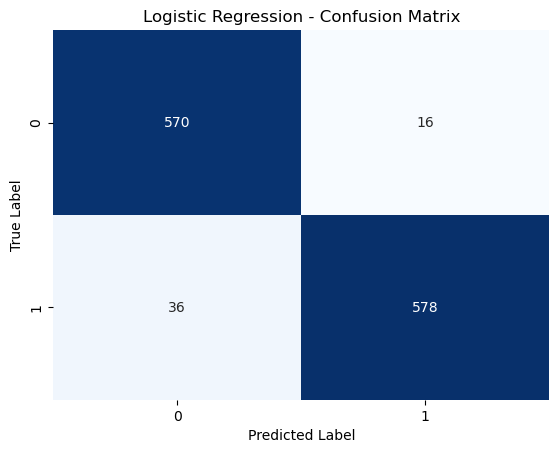

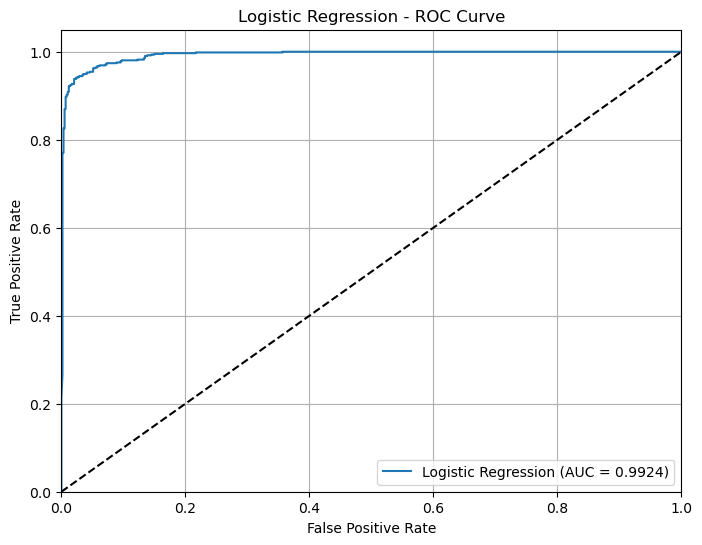

Logistic Regression Performance:
Accuracy: 0.96
Precision: 0.97
Recall (TPR): 0.94
TNR (Specificity): 0.97
F1 Score: 0.96



In [11]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
logistic_metrics = evaluate_model(y_test, y_pred_logistic, 'Logistic Regression', logistic_model, X_test)

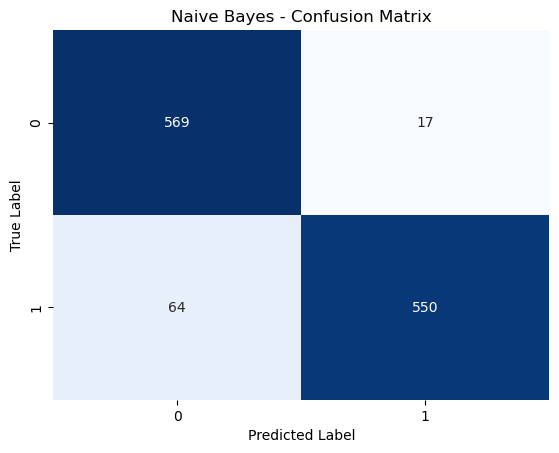

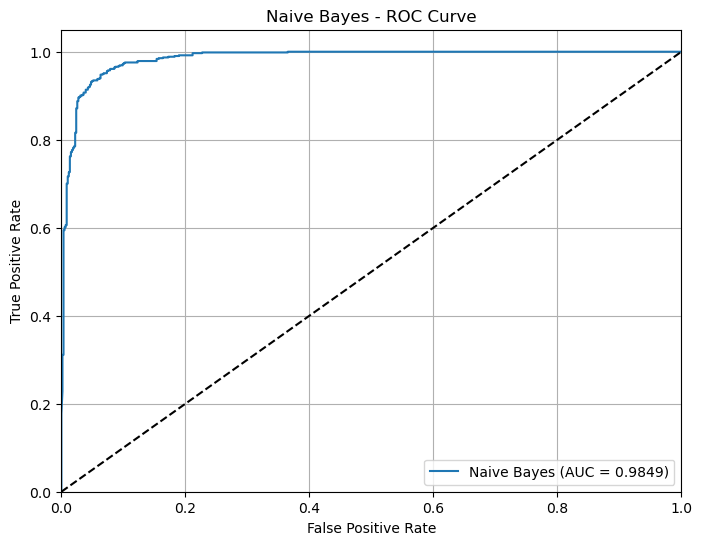

Naive Bayes Performance:
Accuracy: 0.93
Precision: 0.97
Recall (TPR): 0.90
TNR (Specificity): 0.97
F1 Score: 0.93



In [12]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_metrics = evaluate_model(y_test, y_pred_nb, 'Naive Bayes', nb_model, X_test)

In [13]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_metrics = evaluate_model(y_test, y_pred_dt, 'Decision Tree', dt_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


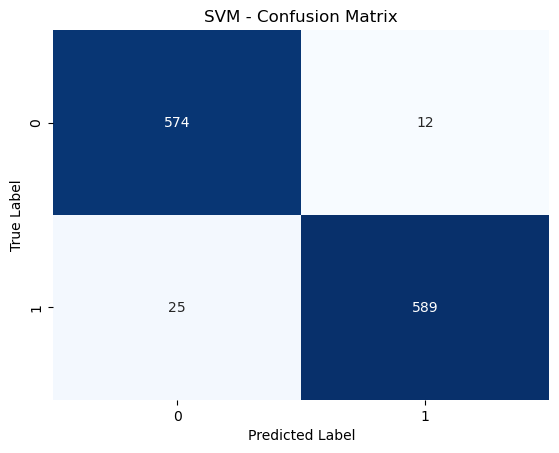

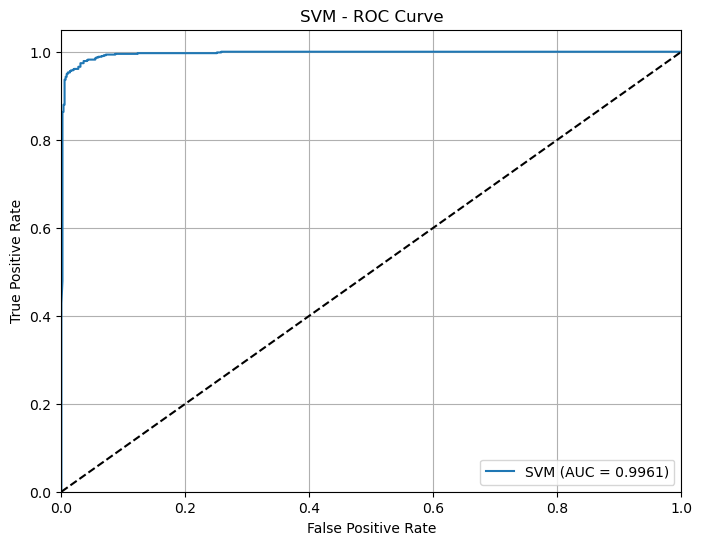

SVM Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97



In [ ]:
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_metrics = evaluate_model(y_test, y_pred_svm, 'SVM', svm_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


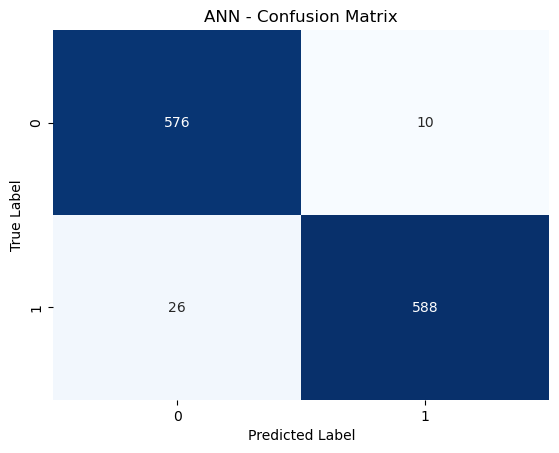

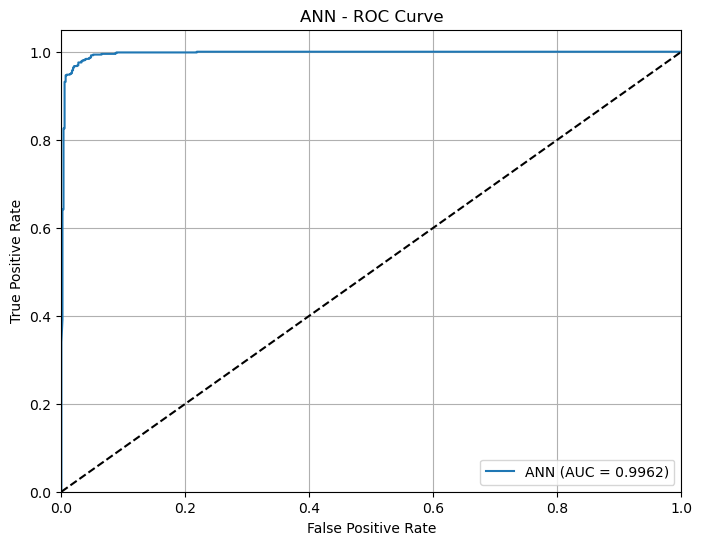

ANN Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97



In [ ]:
ann_model = MLPClassifier(random_state=42, max_iter=300)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)
ann_metrics = evaluate_model(y_test, y_pred_ann, 'ANN', ann_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


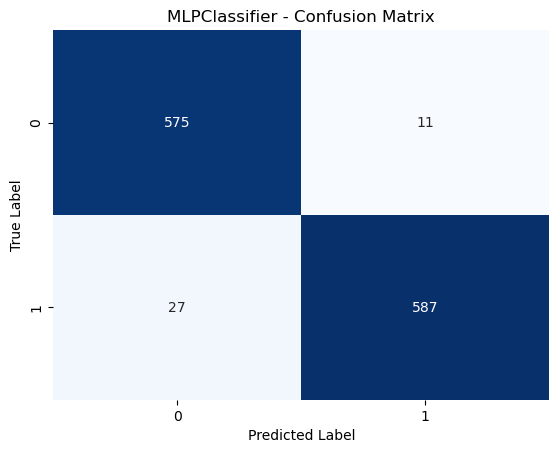

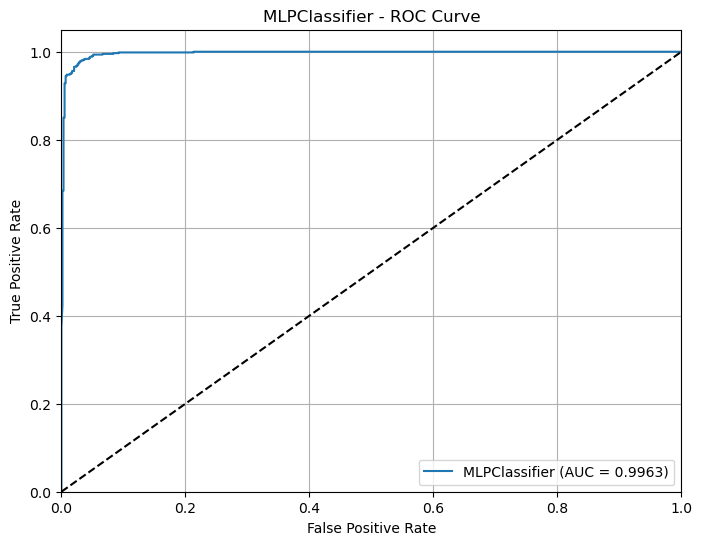

MLPClassifier Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.96
TNR (Specificity): 0.98
F1 Score: 0.97



In [ ]:
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
mlp_metrics = evaluate_model(y_test, y_pred_mlp, 'MLPClassifier', mlp_model, X_test)

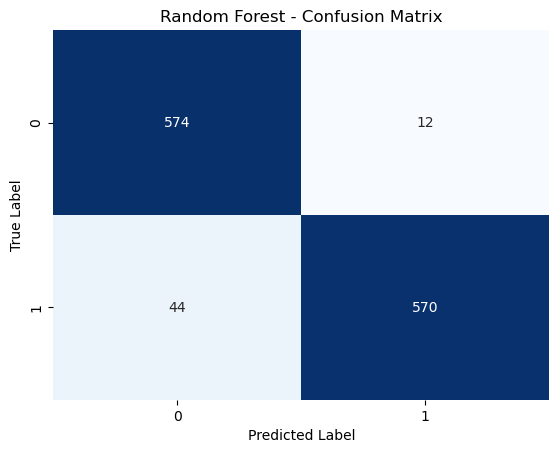

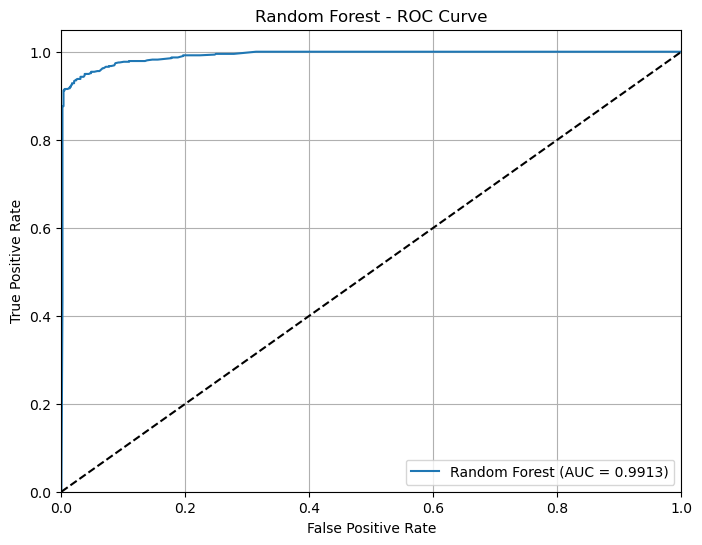

Random Forest Performance:
Accuracy: 0.95
Precision: 0.98
Recall (TPR): 0.93
TNR (Specificity): 0.98
F1 Score: 0.95



In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
rf_metrics = evaluate_model(y_test, y_pred_rf, 'Random Forest', model, X_test)

                 Model  Accuracy  Precision  Recall (TPR)  TNR (Specificity)  \
0  Logistic Regression  0.956667   0.973064      0.941368           0.972696   
1          Naive Bayes  0.932500   0.970018      0.895765           0.970990   
2        Decision Tree  0.928333   0.932787      0.926710           0.930034   
3                  SVM  0.969167   0.980033      0.959283           0.979522   
4                  ANN  0.970000   0.983278      0.957655           0.982935   
5        MLPClassifier  0.968333   0.981605      0.956026           0.981229   
6        Random Forest  0.953333   0.979381      0.928339           0.979522   

   F1 Score  
0  0.956954  
1  0.931414  
2  0.929739  
3  0.969547  
4  0.970297  
5  0.968647  
6  0.953177  


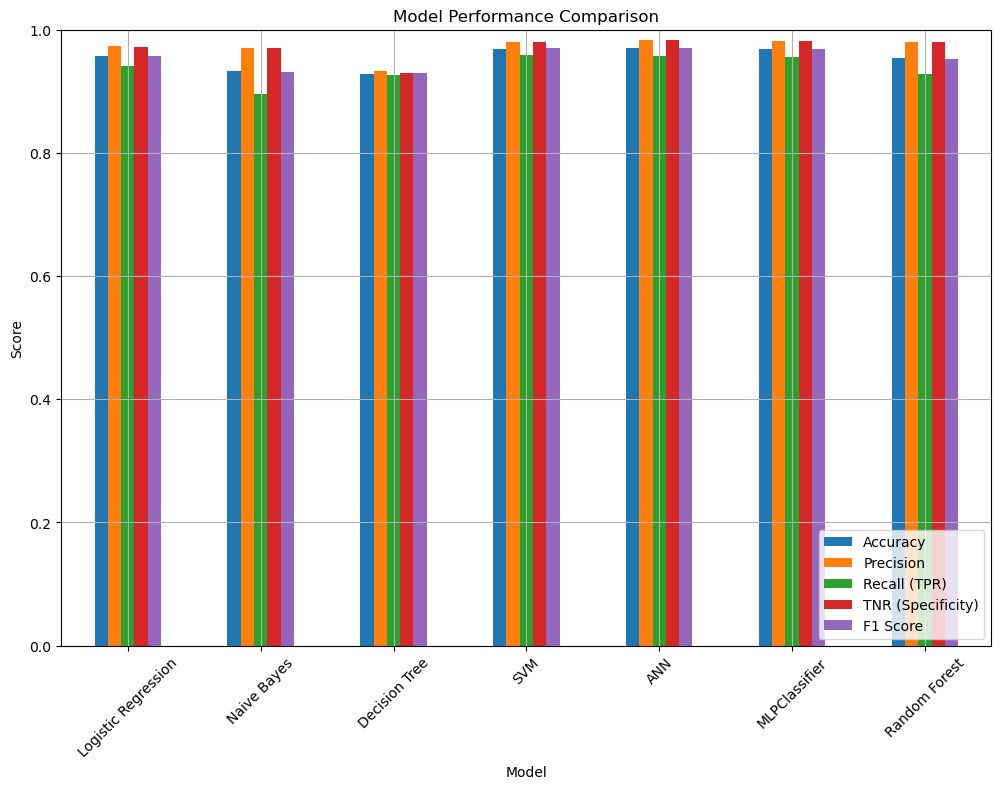

In [ ]:

results = pd.DataFrame([
    logistic_metrics,
    nb_metrics,
    dt_metrics,
    svm_metrics,
    ann_metrics,
    mlp_metrics,
    rf_metrics
])


print(results)


results.set_index('Model').plot(kind='bar', figsize=(12, 8), grid=True)
plt.title('Model Karşılaştırma')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

In [10]:


def extract_features(df):
    def url_length(url):
        return len(url)
    
    def num_subdomains(url):
        return urlparse(url).netloc.count('.')
    
    def is_ip(url):
        return 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', urlparse(url).netloc) else 0
    
    def num_special_chars(url):
        return len(re.findall(r'[^a-zA-Z0-9]', url))
    
    def num_parameters(url):
        return len(urlparse(url).query.split('&')) if urlparse(url).query else 0
    
    def has_https(url):
        return 1 if urlparse(url).scheme == 'https' else 0

    def num_images(url):
        return len(re.findall(r'<img', url, re.IGNORECASE))
    
    def text_length(url):
        return len(url)
    
    def num_keywords(url):
        keywords = ['login', 'secure', 'account', 'update', 'signin', 'verify']
        return sum([1 for keyword in keywords if keyword in url.lower()])
    
    def has_ip(url):
        return 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', url) else 0
    
    df['url_length'] = df['domain'].apply(url_length)
    df['num_subdomains'] = df['domain'].apply(num_subdomains)
    df['is_ip'] = df['domain'].apply(is_ip)
    df['num_special_chars'] = df['domain'].apply(num_special_chars)
    df['num_parameters'] = df['domain'].apply(num_parameters)
    df['has_https'] = df['domain'].apply(has_https)
    df['num_images'] = df['domain'].apply(num_images)
    df['text_length'] = df['domain'].apply(text_length)
    df['num_keywords'] = df['domain'].apply(num_keywords)
    df['has_ip'] = df['domain'].apply(has_ip)

    return df

balanced_data = extract_features(balanced_data)


print(balanced_data.head())

                      domain  label  url_length  num_subdomains  is_ip  \
0         fi4tfn.webwave.dev      1          18               0      0   
1  suggestqueries.google.com      0          25               0      0   
2                    ipfs.io      1           7               0      0   
3    ipfs.eth.aragon.network      1          23               0      0   
4   3-courier.push.apple.com      0          24               0      0   

   num_special_chars  num_parameters  has_https  num_images  text_length  \
0                  2               0          0           0           18   
1                  2               0          0           0           25   
2                  1               0          0           0            7   
3                  3               0          0           0           23   
4                  4               0          0           0           24   

   num_keywords  has_ip  
0             0       0  
1             0       0  
2             0     

In [11]:



def extract_features(df):
    def url_length(url):
        return len(url)
    
    def num_subdomains(url):
        return urlparse(url).netloc.count('.')
    
    def has_ip(url):
        return 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', urlparse(url).netloc) else 0
    
    def num_special_chars(url):
        return len(re.findall(r'[^a-zA-Z0-9]', url))
    
    def num_parameters(url):
        return len(urlparse(url).query.split('&')) if urlparse(url).query else 0
    
    def has_https(url):
        return 1 if urlparse(url).scheme == 'https' else 0

    def num_keywords(url):
        keywords = ['login', 'secure', 'account', 'update', 'signin', 'verify']
        return sum([1 for keyword in keywords if keyword in url.lower()])
    
    df['url_length'] = df['domain'].apply(url_length)
    df['num_subdomains'] = df['domain'].apply(num_subdomains)
    df['has_ip'] = df['domain'].apply(has_ip)
    df['num_special_chars'] = df['domain'].apply(num_special_chars)
    df['num_parameters'] = df['domain'].apply(num_parameters)
    df['has_https'] = df['domain'].apply(has_https)
    df['num_keywords'] = df['domain'].apply(num_keywords)

    return df



balanced_data = extract_features(balanced_data)

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
X_tfidf = vectorizer.fit_transform(balanced_data['domain'])


additional_features = balanced_data[['url_length', 'num_subdomains', 'has_ip', 'num_special_chars',
                                     'num_parameters', 'has_https', 'num_keywords']]

from scipy.sparse import hstack
X = hstack([X_tfidf, additional_features])

y = balanced_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:

def evaluate_model(y_true, y_pred, model_name, model_obj=None, X_test=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'], output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['Phishing']['precision']
    recall = report['Phishing']['recall']
    f1 = report['Phishing']['f1-score']

    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    if model_obj and X_test is not None:
        if hasattr(model_obj, "predict_proba"):
            y_prob = model_obj.predict_proba(X_test)[:, 1]
        else:
            y_prob = model_obj.decision_function(X_test)

        fpr, tpr_curve, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr_curve)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr_curve, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    
    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (TPR): {recall:.2f}')
    print(f'TNR (Specificity): {tnr:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (TPR)': recall,
        'TNR (Specificity)': tnr,
        'F1 Score': f1
    }

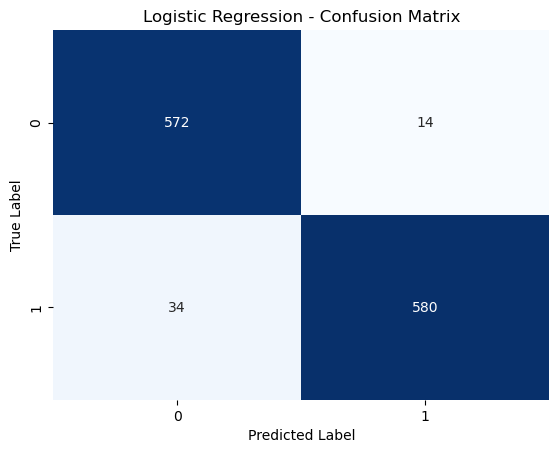

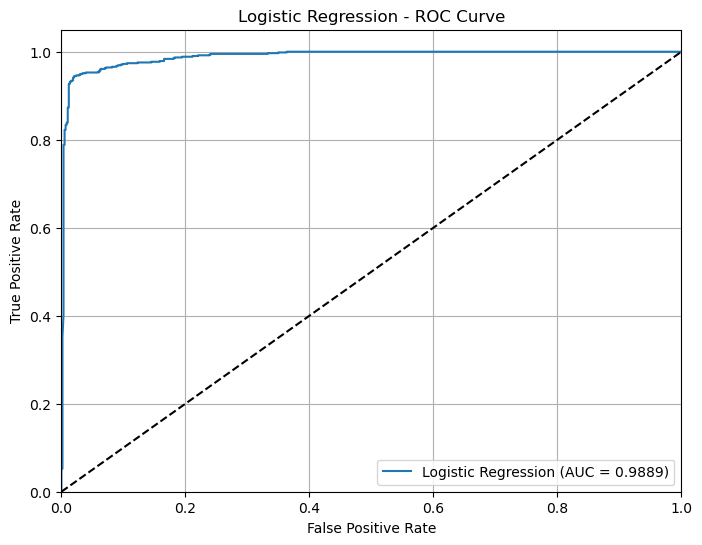

Logistic Regression Performance:
Accuracy: 0.96
Precision: 0.98
Recall (TPR): 0.94
TNR (Specificity): 0.98
F1 Score: 0.96



In [37]:
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
logistic_metrics = evaluate_model(y_test, y_pred_logistic, 'Logistic Regression', logistic_model, X_test)


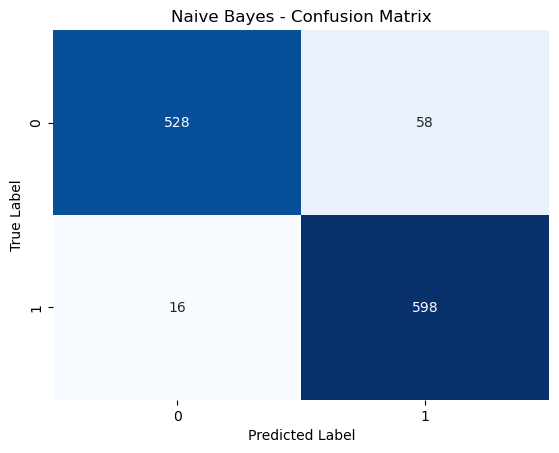

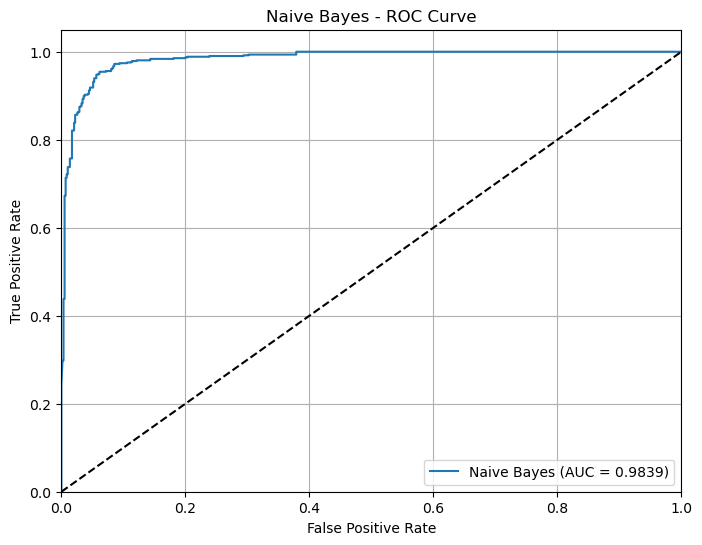

Naive Bayes Performance:
Accuracy: 0.94
Precision: 0.91
Recall (TPR): 0.97
TNR (Specificity): 0.90
F1 Score: 0.94



In [38]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_metrics = evaluate_model(y_test, y_pred_nb, 'Naive Bayes', nb_model, X_test)

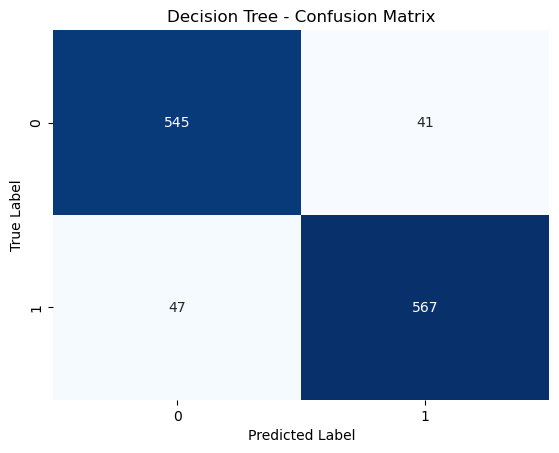

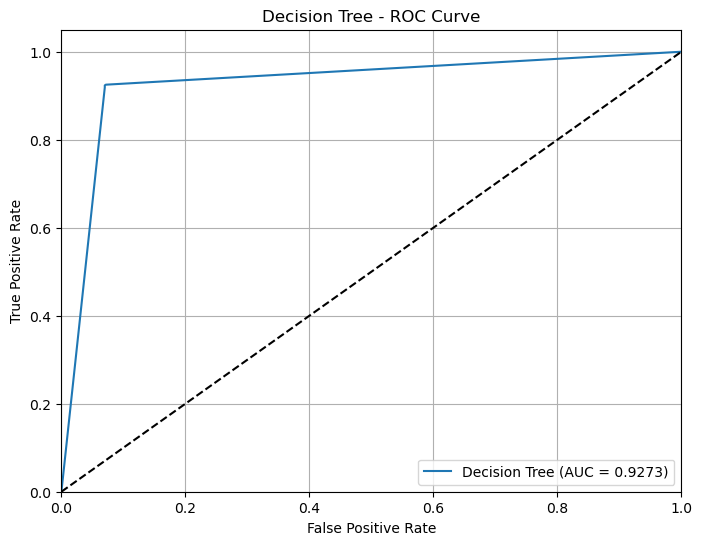

Decision Tree Performance:
Accuracy: 0.93
Precision: 0.93
Recall (TPR): 0.92
TNR (Specificity): 0.93
F1 Score: 0.93



In [39]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_metrics = evaluate_model(y_test, y_pred_dt, 'Decision Tree', dt_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


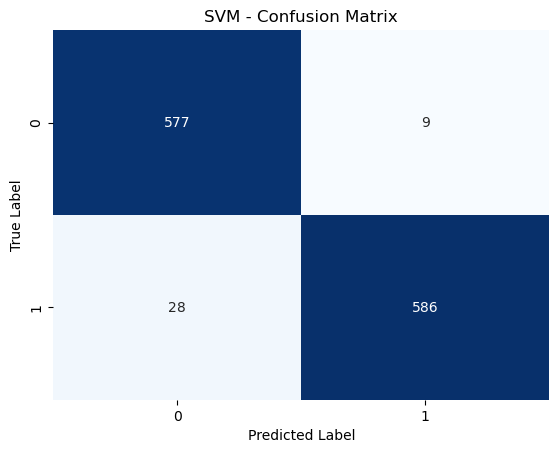

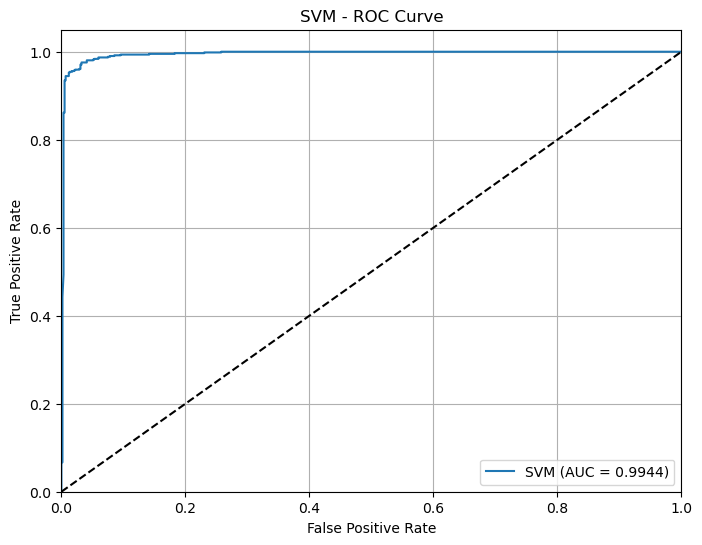

SVM Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.95
TNR (Specificity): 0.98
F1 Score: 0.97



In [40]:
svm_model = LinearSVC(random_state=42, max_iter=1000)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_metrics = evaluate_model(y_test, y_pred_svm, 'SVM', svm_model, X_test)


c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


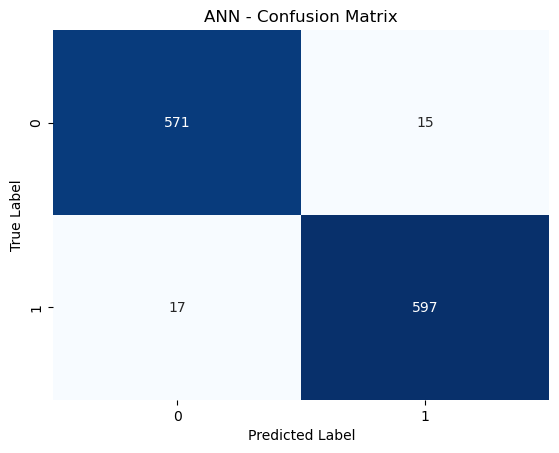

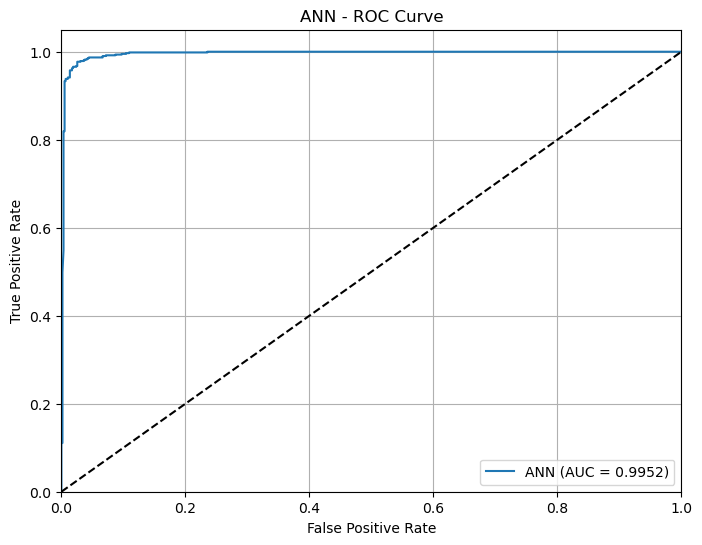

ANN Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.97
TNR (Specificity): 0.97
F1 Score: 0.97



In [41]:
ann_model = MLPClassifier(random_state=42, max_iter=300)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)
ann_metrics = evaluate_model(y_test, y_pred_ann, 'ANN', ann_model, X_test)

c:\Users\deniz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


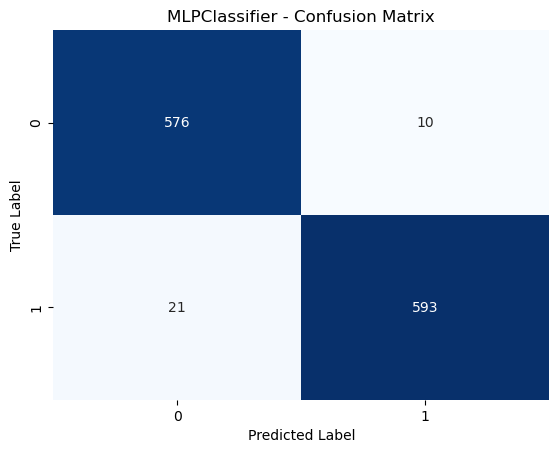

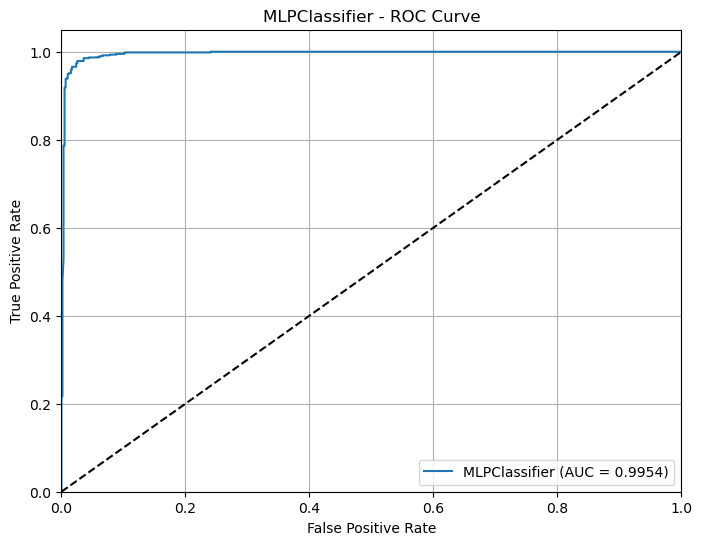

MLPClassifier Performance:
Accuracy: 0.97
Precision: 0.98
Recall (TPR): 0.97
TNR (Specificity): 0.98
F1 Score: 0.97



In [42]:
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
mlp_metrics = evaluate_model(y_test, y_pred_mlp, 'MLPClassifier', mlp_model, X_test)

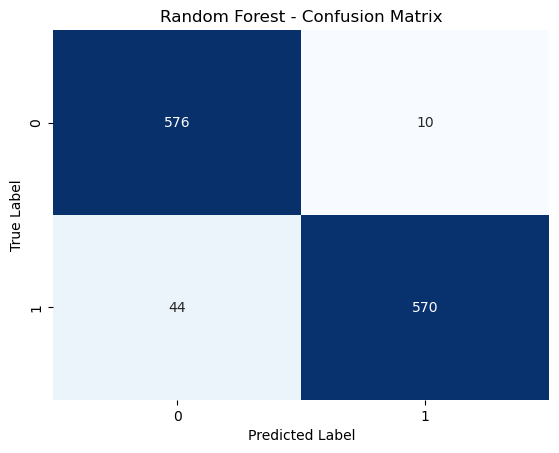

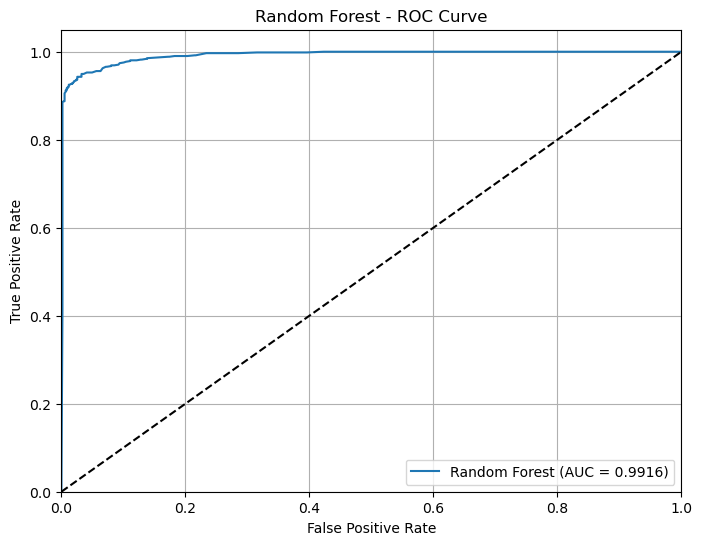

Random Forest Performance:
Accuracy: 0.95
Precision: 0.98
Recall (TPR): 0.93
TNR (Specificity): 0.98
F1 Score: 0.95



In [43]:

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_metrics = evaluate_model(y_test, y_pred_rf, 'Random Forest', rf_model, X_test)

                 Model  Accuracy  Precision  Recall (TPR)  TNR (Specificity)  \
0  Logistic Regression  0.960000   0.976431      0.944625           0.976109   
1          Naive Bayes  0.938333   0.911585      0.973941           0.901024   
2        Decision Tree  0.926667   0.932566      0.923453           0.930034   
3                  SVM  0.969167   0.984874      0.954397           0.984642   
4                  ANN  0.973333   0.975490      0.972313           0.974403   
5        MLPClassifier  0.974167   0.983416      0.965798           0.982935   
6        Random Forest  0.955000   0.982759      0.928339           0.982935   

   F1 Score  
0  0.960265  
1  0.941732  
2  0.927987  
3  0.969396  
4  0.973899  
5  0.974528  
6  0.954774  


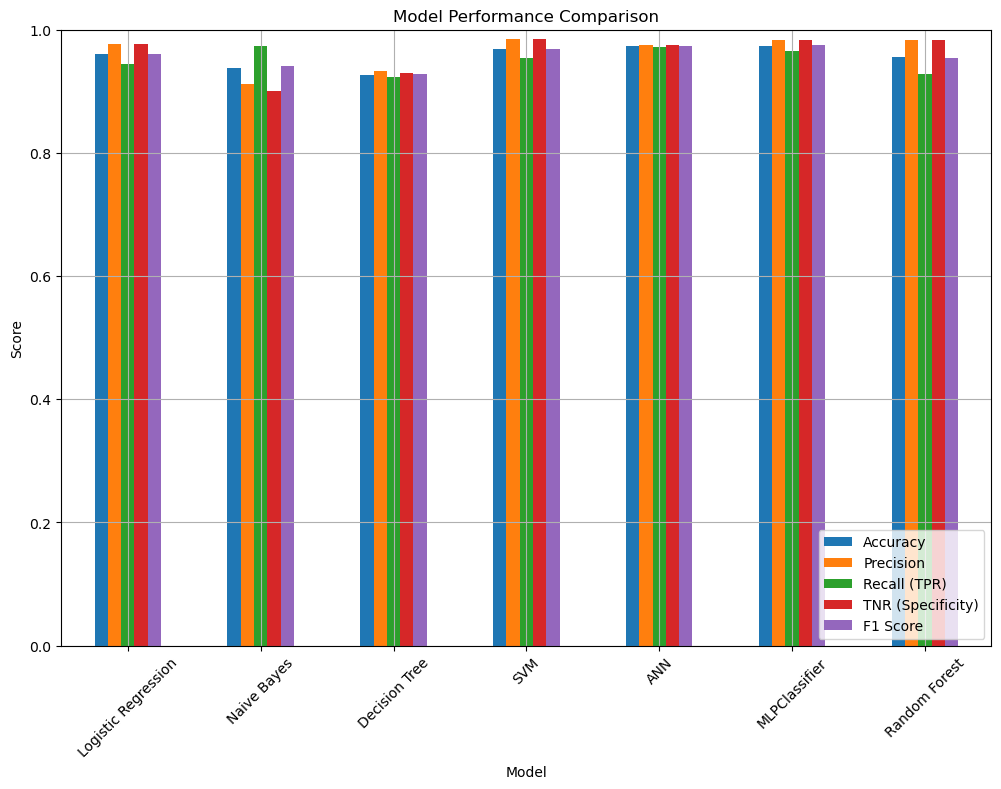

In [44]:

results = pd.DataFrame([
    logistic_metrics,
    nb_metrics,
    dt_metrics,
    svm_metrics,
    ann_metrics,
    mlp_metrics,
    rf_metrics
])

print(results)


results.set_index('Model').plot(kind='bar', figsize=(12, 8), grid=True)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

Bu kod devamında gelen PCA-RF,Normalizasyon,Standardizasyon,Min-Max Scaler ve Hiperparametre Optimizasyonu Kodları başarıyı yeterince etkilemediği için projenin kolay okunabilmesi açısından silinmiştir.